In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/lfw_Train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/lfw_Valid'
test_dir ='/content/drive/MyDrive/ColabNotebooks/lfw_Test'
test_dir_lr='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 239MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 57)

In [ ]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)

    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/ColabNotebooks/capstone_resnetcheckpoint.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
def process_image(gen_image):

    # Process a PIL image for use in a PyTorch model
    #scaled_image= gen_image /255.
    # Converting image to PIL image using image file path
    pil_im = Image.fromarray(gen_image)

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)
    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [ ]:
def predict(gen_image, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model
    loaded_model = load_checkpoint(model)
    # Moving the loaded model to the GPU
    loaded_model.cuda()
    # Pre-processing image
    img = process_image(gen_image)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Moving the input tensor to the GPU
    img_tensor = img_tensor.cuda()
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    input=Variable(img_add_dim)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]

    return conf, predicted



In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(train_dir)

print(classes, c_to_idx)

['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Naomi_Watts', 'Nestor_Kirchner', 'Pete_Sampras', 'Recep_Tayyip_Erdogan', 'Ricardo_Lagos', 'Roh_Moo-hyun', 'Rudolph_Giuliani', 'Saddam_Hussein', 'Serena_Williams', 'Silvio_Berlusconi', 'Tiger_Woods', 'Tom_Daschle', 'Tom_Ridge', 'Tony_Blair', 'Vicente

In [ ]:
from keras.models import load_model
from numpy.random import randint
from tensorflow.keras.preprocessing import image as keras_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
generator = load_model('/content/drive/MyDrive/ColabNotebooks/gen_e7,2.h5',compile=False)

In [ ]:
def preprocess_for_gan(image_path):
    img = keras_image.load_img(image_path + '.jpg', target_size=(96, 96))
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
def gen_image(image):
    image = Image.open(image_path+'.jpg')
    input_for_gan = preprocess_for_gan(image)
    gen_image = generator.predict(input_for_gan)

In [ ]:
def plot_solution(namedir, model, generator, image_path):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/MyDrive/ColabNotebooks/capstone_resnetcheckpoint.pth'
  image_path = test_dir_lr+namedir

  personname = namedir.split('/')[1]

  image = Image.open(image_path+'.jpg')
  input_for_gan = preprocess_for_gan(image_path)
  gen_image = generator.predict(input_for_gan)
  #print("Generated Image Shape:", gen_image.shape)
  #print("Generated Image Array:", gen_image)

   # Reshape and preprocess the GAN-generated image
  gen_image = gen_image.squeeze()  # Remove single-dimensional entries
  gen_image = (gen_image * 255).astype(np.uint8)
  conf2, predicted1 = predict(gen_image, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]


  # Creating PIL image
  #image = Image.open(image_path+'.jpg')
  #input_for_gan = preprocess_for_gan(image)

    # Generate an image using the GAN
  #gen_image = generator.predict(input_for_gan)
  input_image = Image.open(image_path + '.jpg')
  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(3,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(personname)
  ax[1].imshow(gen_image)
  ax[1].set_title("generated_image")
  y_names = np.arange(len(names))
  ax[2].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[2].set_yticks(y_names)
  ax[2].set_yticklabels(names)
  ax[2].invert_yaxis()


  plt.show()

1/1 [==============================] - 0s 29ms/step


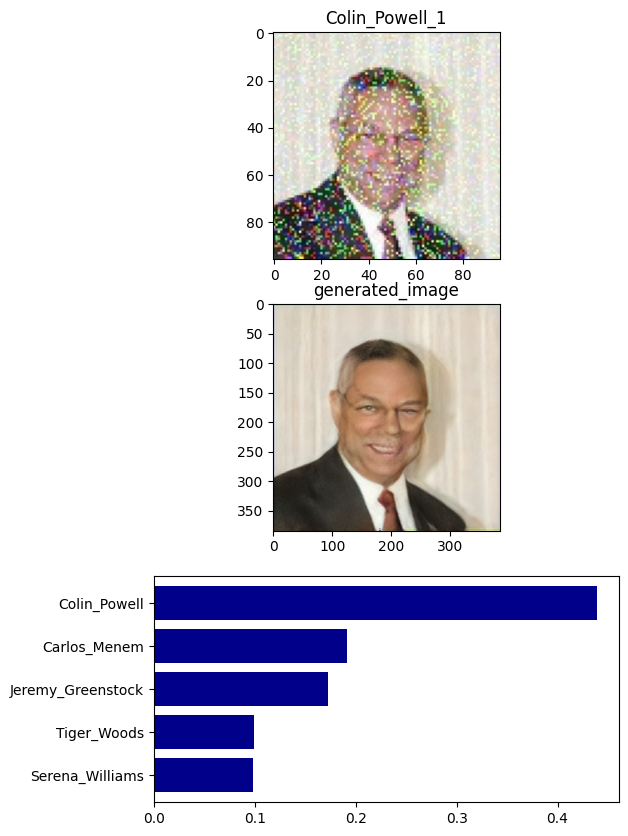

In [ ]:
namedir = '/Colin_Powell_1/Colin_Powell_0207'
image_path = test_dir_lr+namedir
test_dir_lr='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr'
#image_path = '/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr/Colin_Powell_1/Colin_Powell_0166.jpg'
plot_solution(namedir, model, generator, image_path)